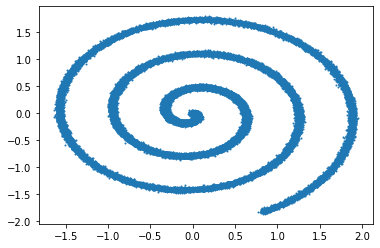

In [1]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


class CustomDataSet(torch.utils.data.Dataset):

    def __init__(self, n_data):

        self.n_data = n_data
        radius = 0.0
        theta = 0.0
        d_theta = -0.005
        d_radius = 0.0005
        self.data = np.random.randn(self.n_data, 2) * 0.02
        n_iter = self.n_data//4000
        idx = 0
        for i in range(4000):
            pos_x = radius * np.cos(theta)
            pos_y = radius * np.sin(theta)
            for j in range(n_iter):
                self.data[idx][0] += pos_x
                self.data[idx][1] += pos_y
                idx += 1
            radius += d_radius
            theta += d_theta
        self.data = torch.from_numpy(self.data).float()

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        return self.data[idx]



data_size = 80000
dataset = CustomDataSet(n_data=data_size)

data_points = dataset.data.numpy()
plt.scatter(data_points[:, 0], data_points[:, 1], s=1)
plt.show()

In [0]:
class NormalDensityNetwork(torch.nn.Module):

    def __init__(self, n_in, n_out):
        super(NormalDensityNetwork, self).__init__()
        self.mean = torch.nn.Linear(in_features=n_in, out_features=n_out, bias=True)
        self.log_var = torch.nn.Linear(in_features=n_in, out_features=n_out, bias=True)

    def forward(self, x):
        return NormalDistributionParameters(self.mean(x), torch.exp(0.5 * self.log_var(x)))


class NormalDistributionParameters(object):

    def __init__(self, mu, sig):
        self.mu = mu
        self.sig = sig

    def sample(self):
        return self.sig * torch.randn_like(self.sig) + self.mu

    def log_likelihood(self, x):
        return -torch.sum(torch.log(self.sig) + 0.5 * (np.log(2.0 * np.pi) + ((self.mu - x)/self.sig)**2), dim=1).mean()

In [0]:
X_dim = 2
Z_dim = 2
mb_size = 64
Q = torch.nn.Sequential(
    torch.nn.Linear(X_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=Z_dim))

P = torch.nn.Sequential(
    torch.nn.Linear(Z_dim, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    torch.nn.Linear(16, 16, bias=True),
    torch.nn.LeakyReLU(0.1),
    NormalDensityNetwork(n_in=16, n_out=X_dim))
    
Q_solver = optim.Adam(Q.parameters(), lr=1e-3)
P_solver = optim.Adam(P.parameters(), lr=1e-3)

In [0]:
def compute_kernel(x, y):

    kernel_input = (x - y).pow(2)/2.0
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel + y_kernel - 2*xy_kernel
    return torch.sum(mmd,dim=1).mean()

In [0]:
loader = DataLoader(dataset, batch_size=mb_size, shuffle=True, drop_last=True)
NLL = []
MMD = []

In [0]:
num_epochs = 100
for epoch in range(num_epochs):
    NLL_CUM = 0.0
    MMD_CUM = 0.0
    for _, X in enumerate(loader):
        Q_solver.zero_grad()
        P_solver.zero_grad()
        distQzx = Q(X)
        qzx = distQzx.sample()
        distPxz = P(qzx)
        mmd = compute_mmd(torch.randn_like(qzx), qzx)
        nll = -distPxz.log_likelihood(X)
        loss = mmd + nll
        loss.backward()
        Q_solver.step()
        P_solver.step() 
        NLL_CUM += nll.item()
        MMD_CUM += mmd.item()
    NLL.append(NLL_CUM/len(loader))
    MMD.append(MMD_CUM/len(loader))

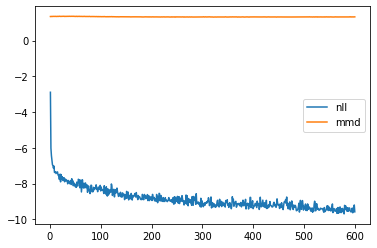

In [24]:
plt.plot(np.arange(1, len(NLL) + 1), NLL, label="nll")
plt.plot(np.arange(1, len(MMD) + 1), MMD, label="mmd")
plt.legend()
plt.show()

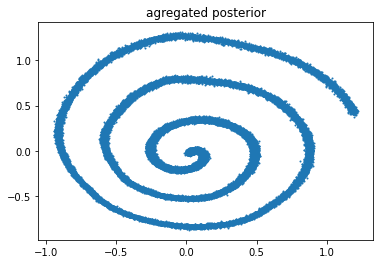

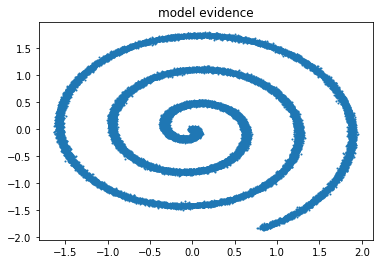

In [27]:
distQzx = Q(dataset.data)
qzx = distQzx.sample()

distPxz = P(qzx)
pxz = distPxz.sample()

qzx = qzx.data.numpy()
pxz = pxz.data.numpy()
plt.title('agregated posterior')
plt.scatter(qzx[:, 0], qzx[:, 1], s=1)
plt.show()
plt.title('model evidence')
plt.scatter(pxz[:, 0], pxz[:, 1], s=1)
plt.show()